In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
import pandas as pd
pd.set_option('display.max_columns', 50)

import category_encoders as ce
from datetime import datetime, timedelta

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

In [2]:
df = pd.read_csv('data.csv')
# display(df.describe())
# display(df.head())

### Class Proportions (Response = 'ordersuccess')

In [3]:
success = df[df['ordersuccess']==1]
fail = df[df['ordersuccess']==0]

success_num = len(success)
fail_num = len(fail)
total = len(df)

print('Number of order successes: ', success_num)
print('Proportion of order successes: ', success_num / (success_num + fail_num))
print('Number of order failures: ', fail_num)
print('Proportion of order failures: ', fail_num / (success_num + fail_num))

Number of order successes:  28190
Proportion of order successes:  0.05021044213331149
Number of order failures:  533247
Proportion of order failures:  0.9497895578666885


### Null Values

In [4]:
# countNaN = len(df) - df.count() #count of NaN values = count of all values (len(df)) - count of non-NaN values (df.count)
# display(countNaN)

## Preprocessing

In [4]:
def getTimeMS(t):
    if '.' in t:
        timestamp, ms = t.split('.')
    else:
        timestamp = t
        ms = 0
    time_obj = datetime.strptime(timestamp, '%H:%M:%S')
    epoch = datetime(1900, 1, 1, 0, 0, 0, 0)
    milliseconds = (time_obj - epoch) // timedelta(milliseconds=1)
    return milliseconds + float(ms)*1000

df['time_ms'] = df['starttime'].apply(lambda x: getTimeMS(x))


#continuous features
cont_features = df.loc[:,['time_ms','size','minexecqty','limitprice','prevailbid','prevailask','prevailbidsize','prevailasksize',
                          'dispatcherrebalance','lotsize','averagespread','misavgbidsize1min','misavgasksize1min', 
                          'misavgspread1min', 'misoddlotvolume1min', 'misadfvolume1min','misvolume1min']]

#one-hot encoded features
dummies = pd.get_dummies(df.loc[:,['side','venuetype','securitycategory', 'peginstruction',
                                   'sector','mktcap']].astype('category'),drop_first=True)

#binary encoded features
enc = ce.BinaryEncoder()
binary_sym = enc.fit_transform(df.loc[:,'symbol'].as_matrix())
names = {'0_0':'symbol_0', '0_1':'symbol_1','0_2':'symbol_2','0_3':'symbol_3','0_4':'symbol_4',
         '0_5':'symbol_5','0_6':'symbol_6','0_7':'symbol_7','0_8':'symbol_8','0_9':'symbol_9',
         '0_10':'symbol_10','0_11':'symbol_11','0_12':'symbol_12'}
binary_sym = binary_sym.rename(columns=names)

binary_venue = enc.fit_transform(df.loc[:,'venue'].as_matrix())
names = {'0_0':'venue_0', '0_1':'venue_1','0_2':'venue_2',
         '0_3':'venue_3','0_4':'venue_4','0_5':'venue_5','0_6':'venue_6'}
binary_venue = binary_venue.rename(columns=names)

adv20d = df.loc[:,'adv20d'].fillna(0)

features = pd.concat([adv20d, cont_features, dummies, binary_sym, binary_venue], axis=1)

response = df.loc[:,'ordersuccess']

df = pd.concat([features,response],axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Train / Test Split

In [5]:
df = df.sample(frac=1)
train = df.head(round(total*.70))
train = train.reset_index(drop=True)
test = df.tail(round(total*.30))
test = test.reset_index(drop=True)

train_success = train[train['ordersuccess']==1]
train_fail = train[train['ordersuccess']==0]

test_success = test[test['ordersuccess']==1]
test_fail = test[test['ordersuccess']==0]

## Downsampling

In [6]:
downsampled_fails = train_fail.sample(n=len(train_success))

#recombine and shuffle data
train_downsampled = pd.concat([downsampled_fails, train_success],axis=0)
train_downsampled = train_downsampled.sample(frac=1).reset_index(drop=True)

train_downsampled.head()

,adv20d,time_ms,size,minexecqty,limitprice,prevailbid,prevailask,prevailbidsize,prevailasksize,dispatcherrebalance,lotsize,averagespread,misavgbidsize1min,misavgasksize1min,misavgspread1min,misoddlotvolume1min,misadfvolume1min,misvolume1min,side_Sell,venuetype_Dark,venuetype_Gray,venuetype_Single-Dealer,securitycategory_COMMON,securitycategory_ETF,securitycategory_FUND,...,sector_Test,sector_Utilities,mktcap_MID,mktcap_SMALL,symbol_0,symbol_1,symbol_2,symbol_3,symbol_4,symbol_5,symbol_6,symbol_7,symbol_8,symbol_9,symbol_10,symbol_11,symbol_12,venue_0,venue_1,venue_2,venue_3,venue_4,venue_5,venue_6,ordersuccess
0,100000.0,37829000.0,300,0,26.34,26.34,26.44,100,600,0,100,0.266875,287,445,0.141880,351,2451,5151,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0
1,3000000.0,38829000.0,800,100,37.93,37.91,37.93,700,1100,0,100,0.020000,841,894,0.017481,103,3505,6102,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
2,0.0,37130000.0,300,0,16.23,16.21,16.23,700,500,0,100,0.033529,700,500,0.020000,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
3,26000000.0,38537000.0,1500,0,33.35,33.34,33.35,50100,10400,0,100,0.010000,35104,13450,0.010000,1329,16479,45465,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,1
4,1500000.0,38297000.0,300,0,25.33,25.32,25.33,1800,500,0,100,0.010000,1238,2949,0.010015,802,84803,131044,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,1,1


## More Data Preparation

In [7]:
train_features = train_downsampled.loc[:,train_downsampled.columns != 'ordersuccess']
train_response = train_downsampled.loc[:,'ordersuccess']

test_features = test.loc[:,test.columns != 'ordersuccess']
test_response = test.loc[:,'ordersuccess']

## Model Evaluation Functions

In [8]:
def cm2df(cm, labels): 
    """converts a numpy array confusion matrix to a pandas dataframe, with class labels"""
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def model_eval(y_test, y_pred): 
    """prints out a confusion matrix (pandas dataframe) and classification report"""
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_as_df=cm2df(conf_mat,[0,1])
    new_names = {0:'Order Fail',1:'Order Success'}
    cm_as_df = cm_as_df.rename(index=new_names, 
                                 columns=new_names)
    print('\n')
    print('CONFUSION MATRIX (predicted along top, actual along side): ')
    display(cm_as_df)

    print('\n')
    print(classification_report(y_test,y_pred,target_names=['Order Fail','Order Success']))
    
def cross_validation(model, features, response, num_folds):
    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    cv = cross_validate(model, features, response, scoring=metrics, cv=num_folds)
    print("Test data set average precision across 5 folds:")
    print(cv['test_precision_macro'])
    print("\nTest data set average recall across 5 folds:")
    print(cv['test_recall_macro'])
    print("\nTest data set average fscore across 5 folds:")
    print(cv['test_f1_macro'])
    
def plot_roc_curve(model, X_test, y_test):
    probabilities = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probabilities)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # plot no skill curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

## Logistic Regression



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,103650,56421
Order Success,2385,5975




               precision    recall  f1-score   support

   Order Fail       0.98      0.65      0.78    160071
Order Success       0.10      0.71      0.17      8360

  avg / total       0.93      0.65      0.75    168431

AUC: 0.719


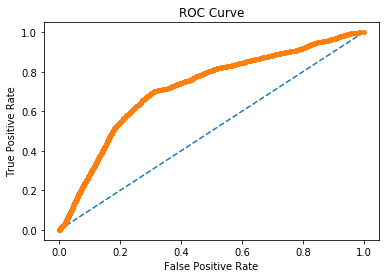

In [9]:
logreg = LogisticRegression()

logreg.fit(train_features, train_response)

y_pred = logreg.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(logreg, test_features, test_response)

# cross_validation(logreg, features, response, 5)

## Decision Tree



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,126429,33642
Order Success,1710,6650




               precision    recall  f1-score   support

   Order Fail       0.99      0.79      0.88    160071
Order Success       0.17      0.80      0.27      8360

  avg / total       0.95      0.79      0.85    168431

AUC: 0.793


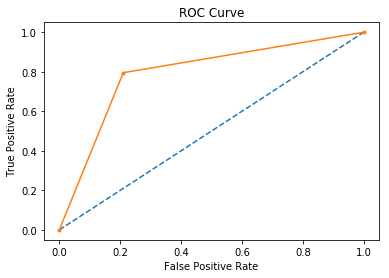

In [10]:
CART = DecisionTreeClassifier()

CART.fit(train_features, train_response)

y_pred = CART.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(CART, test_features, test_response)

# cross_validation(CART, features, response, 5)

## Random Forest



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,132875,27196
Order Success,1358,7002




               precision    recall  f1-score   support

   Order Fail       0.99      0.83      0.90    160071
Order Success       0.20      0.84      0.33      8360

  avg / total       0.95      0.83      0.87    168431

AUC: 0.913


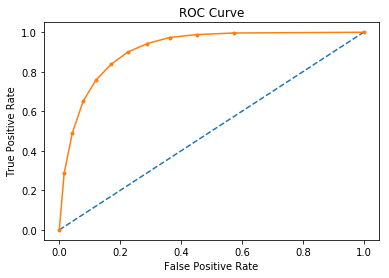

In [11]:
RF = RandomForestClassifier()

RF.fit(train_features, train_response)

y_pred = RF.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(RF, test_features, test_response)

# cross_validation(RF, features, response, 5)

In [18]:
import numpy as np
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [5, 10, 50, 100, 200, 400]

# Number of features to consider at every split
max_features = ['auto', 'log2', None] #'auto' = sqrt(n_features)

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [5, 10, 50, 100, 200, 400]}


In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
RF = RandomForestClassifier()

# the metric used to select the best parameters
f2_score = make_scorer(fbeta_score, beta=1, pos_label=1) #beta = 1 (focus on f1 score), pos_label = 1 (focus on the 1 class)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 50, 
                               cv = 3, verbose=2, scoring=f2_score, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(train_features, train_response)
rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 16.4min finished


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': False}



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,130127,29833
Order Success,847,7624




               precision    recall  f1-score   support

   Order Fail       0.99      0.81      0.89    159960
Order Success       0.20      0.90      0.33      8471

  avg / total       0.95      0.82      0.87    168431

AUC: 0.933


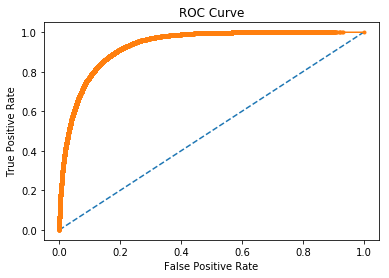

In [22]:
RF_tuned = RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=2,
                           max_features='log2', max_depth=90, bootstrap=False)

RF_tuned.fit(train_features, train_response)

y_pred = RF_tuned.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(RF_tuned, test_features, test_response)

## Tune Random Forest Params with Grid Search

In [ ]:
# narrow down range of considered parameters given by RandomizedSearchCV, then conduct grid search
parameters = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100],
    'max_features': ['log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 400, 600]
}
RF = RandomForestClassifier()

# the metric used to select the best parameters
f2_score = make_scorer(fbeta_score, beta=1, pos_label=1) #beta = 1 (focus on f1 score), pos_label = 1 (focus on the 1 class)
# metric =  "f1_macro"

# apply cross validation and exhaustively search for best parameters
gs_clf = GridSearchCV(RF, param_grid=parameters, scoring=f2_score, cv=3, verbose=2, n_jobs=-1).fit(features, response)

print('Optimal hyperparameters given by grid search:')
for param_name in gs_clf.best_params_:
    print(param_name, gs_clf.best_params_[param_name])

print("best f1 score:", gs_clf.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 259.4min
